### **Modeling**

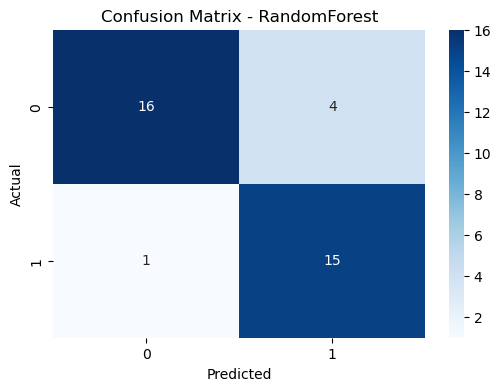

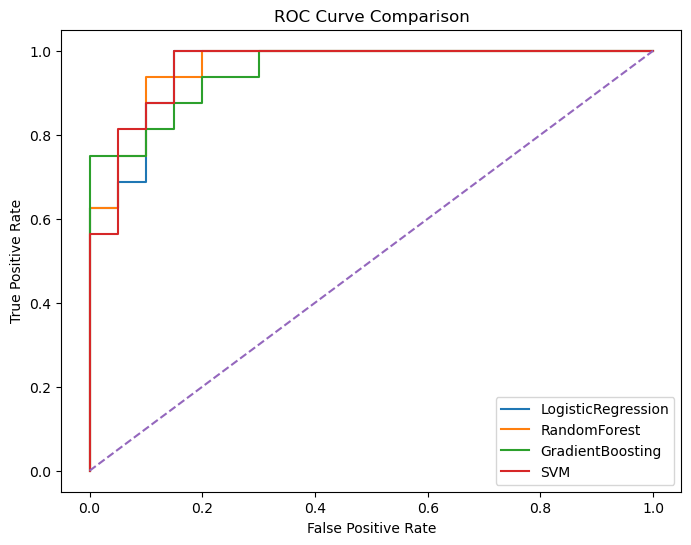

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv(r"C:\Users\Sanjana\Downloads\final_cleaned.csv")

target = None
candidates = ['target','label','output','heart_disease','HeartDisease','y']
for c in candidates:
    if c in df.columns:
        target = c
        break
if target is None:
    for col in df.columns:
        vals = df[col].dropna().unique()
        if set(np.unique(vals)).issubset({0,1}):
            target = col
            break
if target is None:
    target = df.columns[-1]

y = df[target]
X = df.drop(columns=[target])

def to_binary(s):
    if s.dtype.kind in 'iufc':
        return s.astype(int)
    t = s.astype(str).str.lower()
    m = {'yes':1,'y':1,'true':1,'1':1,'no':0,'n':0,'false':0,'0':0}
    u = t.map(m)
    if u.isna().sum()==0:
        return u.astype(int)
    uniq = s.dropna().unique()
    if len(uniq)==2:
        return s.map({uniq[0]:0,uniq[1]:1}).astype(int)
    return pd.to_numeric(s).astype(int)

y = to_binary(y)

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
for col in num_cols[:]:
    if X[col].nunique() <= 6:
        num_cols.remove(col)
        cat_cols.append(col)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=300, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", C=1)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

results = {}
trained = {}

for name, model in models.items():
    pipe = Pipeline([("pre", pre), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    cv = cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring="roc_auc").mean()
    results[name] = {"AUC":roc,"F1":f1,"Accuracy":acc,"Precision":prec,"Recall":rec,"CV_AUC":cv}
    trained[name] = pipe

best = max(results.keys(), key=lambda k: results[k]["AUC"])
best_model = trained[best]
joblib.dump(best_model, "best_model.pkl")

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - " + best)
plt.show()

plt.figure(figsize=(8,6))
for name, model in trained.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


### 1. Random Forest Results:

- **Accuracy:** 0.8611  
- **Precision:** 0.7857  
- **Recall:** 0.9375  
- **F1 Score:** 0.8571  
- **AUC Score:** 0.9625  
- **Cross-Validation AUC:** 0.8659  

These results show that Random Forest is highly effective and consistent.

---

### 2. ROC Curve Analysis

ROC curve helps in visual comparison of all models.
    1. **Logistic Regression**  
    2. **Random Forest**
    3. **GradientBoosting**
    4. **Support Vector Machine (SVM)**  
   

###  Summary:
- Higher curve = better performance  
- Random Forest’s ROC curve covers the largest area  
- AUC of **0.96+** indicates excellent accuracy in class separation  
- Confirms Random Forest is the most dependable model for heart disease prediction  
